# 3 - Correlation and Pattern Prediction

## predicting 3 classes

In [1]:
import pandas as pd
import re 
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
gem = pd.read_csv('task-and-exam-marks-in-groups.csv', delimiter=";", encoding="utf-8")
del gem["Unnamed: 0"]

In [3]:
pd.options.display.max_columns = 50

In [4]:
gem.head()

,tutor,team_id,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,hash2,a1,a2,a3,a4,a5,a6,a7,punkte,note,student_id,pass,subject,semester,faculty,degree
0,tutor2,1.0,10.00,6.5,11.5,13.0,8.5,8.0,10.5,12.5,7.0,13.0,0.0,0afdc45f7ee8e52ebf1afb2970e37b36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,1.0,tec,ba
1,tutor2,1.0,10.00,6.5,11.5,13.0,8.5,8.0,10.5,12.5,7.0,13.0,0.0,d821cd2c7b995d4e3a75c64d25e53529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,inf,1.0,tec,ba
2,tutor1,1146.0,13.75,13.5,14.5,13.5,11.0,11.5,13.5,15.0,14.5,4.0,0.0,fa873577b8543ed8a6d7d8d7fe6ca546,7.0,7.0,8.5,8.0,6.0,7.0,8.5,52.0,3.3,2.0,1.0,inf,1.0,tec,ba
3,tutor3,19.0,13.00,6.5,7.5,9.0,3.5,4.5,5.5,0.0,0.0,0.0,0.0,e7c181a90d7161b4f885a69f6d426474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,inf,1.0,tec,ba
4,tutor5,5012.0,14.00,11.5,12.5,14.5,8.0,7.0,13.5,6.5,8.5,14.0,0.0,e2be9ece8b482afb4717e4e13907a525,4.0,7.0,7.0,8.5,6.5,1.5,4.0,38.5,5.0,4.0,0.0,inf,3.0,tec,ba


## Preparation of Dataset

In [5]:
learn = gem.copy()

In [6]:
learn = learn.drop(learn[learn["punkte"] < 9.0].index)

In [7]:
# fail-pass-line: 42.5 points
learn["pass5"] = 0
learn["pass5"][learn["punkte"] > 37.5] = 1
learn["pass5"][learn["punkte"] >= 47.5] = 2
learn["pass10"] = 0
learn["pass10"][learn["punkte"] > 32.5] = 1
learn["pass10"][learn["punkte"] >= 52.5] = 2
learn["pass15"] = 0
learn["pass15"][learn["punkte"] > 27.5] = 1
learn["pass15"][learn["punkte"] >= 57.5] = 2
#learn["pass20"] = 0
#learn["pass20"][learn["punkte"] > 30] = 1
#learn["pass20"][learn["punkte"] >= 70] = 2

C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\laris\Anaconda3\lib\

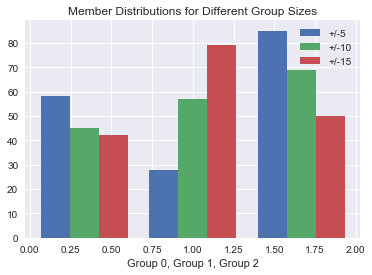

In [8]:
plt.hist([learn["pass5"], learn["pass10"], learn["pass15"]], 
         bins = 3, label=["+/-5", "+/-10", "+/-15"])
plt.legend(loc='upper right')
plt.title("Member Distributions for Different Group Sizes")
plt.xlabel("Group 0, Group 1, Group 2")
plt.show()

In [9]:
learn_only = learn.copy()

In [10]:
del learn_only["hash2"]
del learn_only["a1"]
del learn_only["a2"]
del learn_only["a3"]
del learn_only["a4"]
del learn_only["a5"]
del learn_only["a6"]
del learn_only["a7"]
del learn_only["note"]
del learn_only["punkte"]
del learn_only["student_id"]

In [11]:
target5 = learn_only["pass5"]
target10 = learn_only["pass10"]
target15 = learn_only["pass15"]
#target20 = learn_only["pass20"]

del learn_only["pass5"]

In [12]:
del learn_only["pass10"]
del learn_only["pass15"]
#del learn_only["pass20"]
del learn_only["team_id"]

In [13]:
del learn_only["b6"]
del learn_only["b7"]
del learn_only["b8"]
del learn_only["b9"]
del learn_only["b10"]
del learn_only["b11"]

## Preparation of Evaluation

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def confusion_matrix_report(y_true, y_pred):
	cm, labels = confusion_matrix(y_true, y_pred), unique_labels(y_true, y_pred)
	column_width = max([len(str(x)) for x in labels] + [5])
	report = " " * column_width + " " + "{:_^{}}".format("Prediction", column_width * len(labels))+ "\n"
	report += " " * column_width + " ".join(["{:>{}}".format(label, column_width) for label in labels]) + "\n"
	for i, label1 in enumerate(labels):
		report += "{:>{}}".format(label1, column_width) + " ".join(["{:{}d}".format(cm[i, j], column_width) for j in range(len(labels))]) + "\n"
	return report

In [15]:
def evaluate(model, X_test, y_test):
    prediction = model.predict(X_test)
    y_pred = X_test.assign(prediction = prediction)
    y_pred = y_pred.assign(true = y_test)
    print(confusion_matrix_report(y_pred["true"], y_pred["prediction"]))
    print(accuracy_score(y_pred["true"], y_pred["prediction"]))
    print(classification_report(y_pred["true"], y_pred["prediction"]))

## Data Preparation

In [16]:
learn.columns

Index(['tutor', 'team_id', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8',
       'b9', 'b10', 'b11', 'hash2', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7',
       'punkte', 'note', 'student_id', 'pass', 'subject', 'semester',
       'faculty', 'degree', 'pass5', 'pass10', 'pass15'],
      dtype='object')

In [17]:
learn_only.columns

Index(['tutor', 'b1', 'b2', 'b3', 'b4', 'b5', 'pass', 'subject', 'semester',
       'faculty', 'degree'],
      dtype='object')

In [18]:
del learn_only["faculty"]
del learn_only["tutor"]
del learn_only["subject"]
learn_only = pd.get_dummies(learn_only)
del learn_only["degree_ext"]
learn_only = learn_only.replace(np.nan, "0")
learn_only.head()

,b1,b2,b3,b4,b5,pass,semester,degree_ba,degree_ma
2,13.75,13.5,14.5,13.5,11,1.0,1,1,0
4,14,11.5,12.5,14.5,8,0.0,3,1,0
5,15,14.5,15,15,15,1.0,1,1,0
6,13.5,11,13,9.5,3.5,0.0,1,1,0
7,14.5,13,12,9.5,2.5,1.0,1,1,0


In [19]:
from sklearn.model_selection import train_test_split
X_train5, X_test5, y_train5, y_test5 = train_test_split(learn_only, target5, test_size=0.15, random_state=41)
X_train10, X_test10, y_train10, y_test10 = train_test_split(learn_only, target10, test_size=0.15, random_state=42)
X_train15, X_test15, y_train15, y_test15 = train_test_split(learn_only, target15, test_size=0.15, random_state=42)
#X_train20, X_test20, y_train20, y_test20 = train_test_split(learn_only, target20, test_size=0.15, random_state=42)
print(X_train15.shape, y_train15.shape)
#print(y_test5)

(145, 9) (145,)


# Naive Bayes (as Baseline Model)

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train5, y_train5)
evaluate(naive_bayes, X_test5, y_test5)

      __Prediction___
         0     1     2
    0   10     0     0
    1    1     0     5
    2    0     0    10

0.769230769231
             precision    recall  f1-score   support

          0       0.91      1.00      0.95        10
          1       0.00      0.00      0.00         6
          2       0.67      1.00      0.80        10

avg / total       0.61      0.77      0.67        26



C:\Users\laris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train10, y_train10)
evaluate(naive_bayes, X_test10, y_test10)

      __Prediction___
         0     1     2
    0    9     0     0
    1    1     2     3
    2    0     0    11

0.846153846154
             precision    recall  f1-score   support

          0       0.90      1.00      0.95         9
          1       1.00      0.33      0.50         6
          2       0.79      1.00      0.88        11

avg / total       0.87      0.85      0.82        26



In [23]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train15, y_train15)
evaluate(naive_bayes, X_test15, y_test15)

      __Prediction___
         0     1     2
    0    9     0     0
    1    1     2     5
    2    0     0     9

0.769230769231
             precision    recall  f1-score   support

          0       0.90      1.00      0.95         9
          1       1.00      0.25      0.40         8
          2       0.64      1.00      0.78         9

avg / total       0.84      0.77      0.72        26



In [24]:
#naive_bayes = GaussianNB()
#naive_bayes.fit(X_train20, y_train20)
#evaluate(naive_bayes, X_test20, y_test20)

# Decision Tree

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
# for depth in [1,2,3,4,5,6,7,8,9]:    
# 	decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
# 	cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# 	acc_each_split = cross_val_score(decision_tree, learn_only, target5, cv=cross_val, scoring='accuracy')
# 	decision_tree.fit(learn_only, target5)
# 	print("tree with depth= {} and {} nodes has accuracy {}".format(depth, decision_tree.tree_.node_count,acc_each_split.mean()))

In [26]:
# for depth in [1,2,3,4,5,6,7,8,9]:    
# 	decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
# 	cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# 	acc_each_split = cross_val_score(decision_tree, learn_only, target10, cv=cross_val, scoring='accuracy')
# 	decision_tree.fit(learn_only, target10)
# 	print("tree with depth= {} and {} nodes has accuracy {}".format(depth, decision_tree.tree_.node_count,acc_each_split.mean()))

In [27]:
# for depth in [1,2,3,4,5,6,7,8,9]:    
# 	decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
# 	cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# 	acc_each_split = cross_val_score(decision_tree, learn_only, target15, cv=cross_val, scoring='accuracy')
# 	decision_tree.fit(learn_only, target15)
# 	print("tree with depth= {} and {} nodes has accuracy {}".format(depth, decision_tree.tree_.node_count,acc_each_split.mean()))

In [28]:
#for depth in [1,2,3,4,5,6,7,8,9]:    
#	decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
#	cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#	acc_each_split = cross_val_score(decision_tree, learn_only, target20, cv=cross_val, scoring='accuracy')
#	decision_tree.fit(learn_only, target20)
#	print("tree with depth= {} and {} nodes has accuracy {}".format(depth, decision_tree.tree_.node_count,acc_each_split.mean()))

In [29]:
decision_tree = tree.DecisionTreeClassifier(max_depth=6)
decision_tree.fit(X_train5, y_train5)
evaluate(decision_tree, X_test5, y_test5)

      __Prediction___
         0     1     2
    0    7     3     0
    1    0     1     5
    2    0     0    10

0.692307692308
             precision    recall  f1-score   support

          0       1.00      0.70      0.82        10
          1       0.25      0.17      0.20         6
          2       0.67      1.00      0.80        10

avg / total       0.70      0.69      0.67        26



In [30]:
decision_tree = tree.DecisionTreeClassifier(max_depth=2)
decision_tree.fit(X_train10, y_train10)
evaluate(decision_tree, X_test10, y_test10)

      __Prediction___
         0     1     2
    0    6     3     0
    1    0     3     3
    2    0     0    11

0.769230769231
             precision    recall  f1-score   support

          0       1.00      0.67      0.80         9
          1       0.50      0.50      0.50         6
          2       0.79      1.00      0.88        11

avg / total       0.79      0.77      0.76        26



In [31]:
decision_tree = tree.DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_train15, y_train15)
evaluate(decision_tree, X_test15, y_test15)

      __Prediction___
         0     1     2
    0    6     3     0
    1    0     7     1
    2    0     6     3

0.615384615385
             precision    recall  f1-score   support

          0       1.00      0.67      0.80         9
          1       0.44      0.88      0.58         8
          2       0.75      0.33      0.46         9

avg / total       0.74      0.62      0.62        26



In [32]:
#decision_tree = tree.DecisionTreeClassifier(max_depth=6)
#decision_tree.fit(X_train20, y_train20)
#evaluate(decision_tree, X_test20, y_test20)

# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
# for estimators in [10, 20, 30, 40, 50, 60]:
#     for depth in [1,2,3,4,5,6,7,8,9]:    
#         rf_model =  RandomForestClassifier(max_depth=depth, n_estimators=estimators)
#         cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#         acc_each_split = cross_val_score(rf_model, X_train5, y_train5, cv=cross_val, scoring='accuracy')
#         rf_model.fit(X_test5, y_test5)
#         print("tree with depth= {} and estimators= {} has accuracy {}".format(depth, estimators, acc_each_split.mean()))

In [35]:
rf_model =  RandomForestClassifier(max_depth=1,n_estimators=20)
rf_model.fit(X_train5, y_train5)
evaluate(rf_model, X_test5, y_test5)

      __Prediction___
         0     1     2
    0    8     0     2
    1    0     0     6
    2    0     0    10

0.692307692308
             precision    recall  f1-score   support

          0       1.00      0.80      0.89        10
          1       0.00      0.00      0.00         6
          2       0.56      1.00      0.71        10

avg / total       0.60      0.69      0.62        26



C:\Users\laris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
# for estimators in [10, 20, 30, 40, 50, 60]:
#     for depth in [1,2,3,4,5,6,7,8,9]:    
#         rf_model =  RandomForestClassifier(max_depth=depth, n_estimators=estimators)
#         cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#         acc_each_split = cross_val_score(rf_model, X_train10, y_train10, cv=cross_val, scoring='accuracy')
#         rf_model.fit(X_test10, y_test10)
#         print("tree with depth= {} and estimators= {} has accuracy {}".format(depth, estimators, acc_each_split.mean()))

In [37]:
rf_model =  RandomForestClassifier(max_depth=9, n_estimators=30, random_state=42)
rf_model.fit(X_train10, y_train10)
evaluate(rf_model, X_test10, y_test10)

      __Prediction___
         0     1     2
    0    6     3     0
    1    1     4     1
    2    0     2     9

0.730769230769
             precision    recall  f1-score   support

          0       0.86      0.67      0.75         9
          1       0.44      0.67      0.53         6
          2       0.90      0.82      0.86        11

avg / total       0.78      0.73      0.75        26



In [38]:
# for estimators in [10, 20, 30, 40, 50, 60]:
#     for depth in [1,2,3,4,5,6,7,8,9]:    
#         rf_model =  RandomForestClassifier(max_depth=depth, n_estimators=estimators)
#         cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#         acc_each_split = cross_val_score(rf_model, X_train15, y_train15, cv=cross_val, scoring='accuracy')
#         rf_model.fit(X_test15, y_test15)
#         print("tree with depth= {} and estimators= {} has accuracy {}".format(depth, estimators, acc_each_split.mean()))

In [39]:
rf_model =  RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)
rf_model.fit(X_train15, y_train15)
evaluate(rf_model, X_test15, y_test15)

      __Prediction___
         0     1     2
    0    6     3     0
    1    0     5     3
    2    0     5     4

0.576923076923
             precision    recall  f1-score   support

          0       1.00      0.67      0.80         9
          1       0.38      0.62      0.48         8
          2       0.57      0.44      0.50         9

avg / total       0.66      0.58      0.60        26



In [40]:
#for estimators in [10, 20, 30, 40, 50, 60]:
#    for depth in [1,2,3,4,5,6,7,8,9]:    
#        rf_model =  RandomForestClassifier(max_depth=depth, n_estimators=estimators)
#        cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#        acc_each_split = cross_val_score(rf_model, X_train20, y_train20, cv=cross_val, scoring='accuracy')
#        rf_model.fit(X_test20, y_test20)
#        print("tree with depth= {} and estimators= {} has accuracy {}".format(depth, estimators, acc_each_split.mean()))

In [41]:
#rf_model =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
#rf_model.fit(X_train20, y_train20)
#evaluate(rf_model, X_test20, y_test20)

## show prediction improvement over weeks

In [42]:
def f_one(model, y, X, z):
    pred = model.predict(X)
    true = y
    matrix = confusion_matrix(true, pred)
    if z == 0:
        recall = matrix[0,0] / (matrix[0,0] + matrix[0,1] + matrix[0,2])
        precision = matrix[0,0] / (matrix[0,0] + matrix[1,0] + matrix[2,0])
    elif z == 1:
        recall = matrix[1,1] / (matrix[1,0] + matrix[1,1] + matrix[1,2])
        precision = matrix[1,1] / (matrix[0,1] + matrix[1,1] + matrix[2,1])
    elif z == 2:
        recall = matrix[2,2] / (matrix[2,0] + matrix[2,1] + matrix[2,2])
        precision = matrix[2,2] / (matrix[0,2] + matrix[1,2] + matrix[2,2])
    else:
        print("this was not a correct category")
        recall = 0
        precision = 0
    fone = (2 * precision * recall) / (precision + recall)
    return(fone)

In [43]:
learn_weeks = learn.copy()
del learn_weeks["hash2"]
del learn_weeks["a1"]
del learn_weeks["a2"]
del learn_weeks["a3"]
del learn_weeks["a4"]
del learn_weeks["a5"]
del learn_weeks["a6"]
del learn_weeks["a7"]
del learn_weeks["note"]
del learn_weeks["punkte"]
del learn_weeks["student_id"]

del learn_weeks["pass5"]
del learn_weeks["pass10"]
del learn_weeks["pass15"]
#del learn_weeks["pass20"]
del learn_weeks["team_id"]

del learn_weeks["faculty"]
del learn_weeks["tutor"]
del learn_weeks["subject"]
learn_weeks = pd.get_dummies(learn_weeks)
del learn_weeks["degree_ext"]
learn_weeks = learn_weeks.replace(np.nan, "0")
#learn_weeks.head()

In [44]:
week1 = learn_weeks.copy()
del week1["b2"]
del week1["b3"]
del week1["b4"]
del week1["b5"]
del week1["b6"]
del week1["b7"]
del week1["b8"]
del week1["b9"]
del week1["b10"]
del week1["b11"]

week2 = learn_weeks.copy()
del week2["b3"]
del week2["b4"]
del week2["b5"]
del week2["b6"]
del week2["b7"]
del week2["b8"]
del week2["b9"]
del week2["b10"]
del week2["b11"]

week3 = learn_weeks.copy()
del week3["b4"]
del week3["b5"]
del week3["b6"]
del week3["b7"]
del week3["b8"]
del week3["b9"]
del week3["b10"]
del week3["b11"]

week4 = learn_weeks.copy()
del week4["b5"]
del week4["b6"]
del week4["b7"]
del week4["b8"]
del week4["b9"]
del week4["b10"]
del week4["b11"]

week5 = learn_weeks.copy()
del week5["b6"]
del week5["b7"]
del week5["b8"]
del week5["b9"]
del week5["b10"]
del week5["b11"]

week6 = learn_weeks.copy()
del week6["b7"]
del week6["b8"]
del week6["b9"]
del week6["b10"]
del week6["b11"]

week7 = learn_weeks.copy()
del week7["b8"]
del week7["b9"]
del week7["b10"]
del week7["b11"]

week8 = learn_weeks.copy()
del week8["b9"]
del week8["b10"]
del week8["b11"]

week9 = learn_weeks.copy()
del week9["b10"]
del week9["b11"]

week10 = learn_weeks.copy()
del week10["b11"]

week11 = learn_weeks.copy()

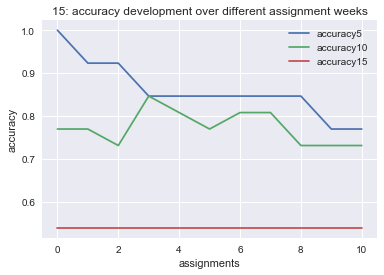

In [45]:
from sklearn.model_selection import train_test_split
X_train1, X_test1 = train_test_split(week1, test_size=0.15, random_state=42)
X_train2, X_test2 = train_test_split(week2, test_size=0.15, random_state=42)
X_train3, X_test3 = train_test_split(week3, test_size=0.15, random_state=42)
X_train4, X_test4 = train_test_split(week4, test_size=0.15, random_state=42)
X_train5, X_test5 = train_test_split(week5, test_size=0.15, random_state=42)
X_train6, X_test6 = train_test_split(week6, test_size=0.15, random_state=42)
X_train7, X_test7 = train_test_split(week7, test_size=0.15, random_state=42)
X_train8, X_test8 = train_test_split(week8, test_size=0.15, random_state=42)
X_train9, X_test9 = train_test_split(week9, test_size=0.15, random_state=42)
X_train10, X_test10 = train_test_split(week10, test_size=0.15, random_state=42)
X_train11, X_test11 = train_test_split(week11, test_size=0.15, random_state=42)

y_train5, y_test5 = train_test_split(target5, test_size=0.15, random_state=42)
y_train10, y_test10 = train_test_split(target10, test_size=0.15, random_state=42)
y_train15, y_test15 = train_test_split(target15, test_size=0.15, random_state=42)
#y_train20, y_test20 = train_test_split(target20, test_size=0.15, random_state=42)

#########################################################################################

dt_model51 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model51.fit(X_train1,y_train5)
dt_model52 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model52.fit(X_train2,y_train5)
dt_model53 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model53.fit(X_train3,y_train5)
dt_model54 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model54.fit(X_train4,y_train5)
dt_model55 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model55.fit(X_train5,y_train5)
dt_model56 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model56.fit(X_train6,y_train5)
dt_model57 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model57.fit(X_train7,y_train5)
dt_model58 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model58.fit(X_train8,y_train5)
dt_model59 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model59.fit(X_train9,y_train5)
dt_model510 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model510.fit(X_train10,y_train5)
dt_model511 =  tree.DecisionTreeClassifier(max_depth=4)
dt_model511.fit(X_train11,y_train5)


acc5 = pd.Series([accuracy_score(y_test5, dt_model51.predict(X_test1)), 
                accuracy_score(y_test5, dt_model52.predict(X_test2)),
                accuracy_score(y_test5, dt_model53.predict(X_test3)),
                accuracy_score(y_test5, dt_model54.predict(X_test4)),
                accuracy_score(y_test5, dt_model55.predict(X_test5)),
                accuracy_score(y_test5, dt_model56.predict(X_test6)),
                accuracy_score(y_test5, dt_model57.predict(X_test7)),
                accuracy_score(y_test5, dt_model58.predict(X_test8)),
                accuracy_score(y_test5, dt_model59.predict(X_test9)),
                accuracy_score(y_test5, dt_model510.predict(X_test10)),
                accuracy_score(y_test5, dt_model511.predict(X_test11))])
				
df = pd.DataFrame({"accuracy5" : acc5})

# f1_5_0 = pd.Series([f_one(dt_model51, y_test5, X_test1, 0), 
#                    f_one(dt_model52, y_test5, X_test2, 0), 
#                    f_one(dt_model53, y_test5, X_test3, 0), 
#                    f_one(dt_model54, y_test5, X_test4, 0), 
#                    f_one(dt_model55, y_test5, X_test5, 0), 
#                    f_one(dt_model56, y_test5, X_test6, 0), 
#                    f_one(dt_model57, y_test5, X_test7, 0), 
#                    f_one(dt_model58, y_test5, X_test8, 0), 
#                    f_one(dt_model59, y_test5, X_test9, 0), 
#                    f_one(dt_model510, y_test5, X_test10, 0),
#                    f_one(dt_model511, y_test5, X_test11, 0)])
# f1_5_1 = pd.Series([f_one(dt_model51, y_test5, X_test1, 1), 
#                    f_one(dt_model52, y_test5, X_test2, 1), 
#                    f_one(dt_model53, y_test5, X_test3, 1), 
#                    f_one(dt_model54, y_test5, X_test4, 1), 
#                    f_one(dt_model55, y_test5, X_test5, 1), 
#                    f_one(dt_model56, y_test5, X_test6, 1), 
#                    f_one(dt_model57, y_test5, X_test7, 1), 
#                    f_one(dt_model58, y_test5, X_test8, 1), 
#                    f_one(dt_model59, y_test5, X_test9, 1), 
#                    f_one(dt_model510, y_test5, X_test10, 1),
#                    f_one(dt_model511, y_test5, X_test11, 1)])
# f1_5_2 = pd.Series([f_one(dt_model51, y_test5, X_test1, 2), 
#                    f_one(dt_model52, y_test5, X_test2, 2), 
#                    f_one(dt_model53, y_test5, X_test3, 2), 
#                    f_one(dt_model54, y_test5, X_test4, 2), 
#                    f_one(dt_model55, y_test5, X_test5, 2), 
#                    f_one(dt_model56, y_test5, X_test6, 2), 
#                    f_one(dt_model57, y_test5, X_test7, 2), 
#                    f_one(dt_model58, y_test5, X_test8, 2), 
#                    f_one(dt_model59, y_test5, X_test9, 2), 
#                    f_one(dt_model510, y_test5, X_test10, 2),
#                    f_one(dt_model511, y_test5, X_test11, 2)])
				
# df = df.assign(f1_5_0 = f1_5_0)
# df = df.assign(f1_5_1 = f1_5_1)
# df = df.assign(f1_5_2 = f1_5_2)
				
#plt.hist(df["week"])
plt.plot(df["accuracy5"])
plt.xlabel('assignments')
plt.ylabel('accuracy')
plt.title('5: accuracy development over different assignment weeks')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

dt_model101 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model101.fit(X_train1,y_train10)
dt_model102 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model102.fit(X_train2,y_train10)
dt_model103 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model103.fit(X_train3,y_train10)
dt_model104 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model104.fit(X_train4,y_train10)
dt_model105 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model105.fit(X_train5,y_train10)
dt_model106 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model106.fit(X_train6,y_train10)
dt_model107 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model107.fit(X_train7,y_train10)
dt_model108 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model108.fit(X_train8,y_train10)
dt_model109 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model109.fit(X_train9,y_train10)
dt_model1010 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model1010.fit(X_train10,y_train10)
dt_model1011 =  tree.DecisionTreeClassifier(max_depth=5)
dt_model1011.fit(X_train11,y_train10)


acc10 = pd.Series([accuracy_score(y_test10, dt_model101.predict(X_test1)), 
                accuracy_score(y_test10, dt_model102.predict(X_test2)),
                accuracy_score(y_test10, dt_model103.predict(X_test3)),
                accuracy_score(y_test10, dt_model104.predict(X_test4)),
                accuracy_score(y_test10, dt_model105.predict(X_test5)),
                accuracy_score(y_test10, dt_model106.predict(X_test6)),
                accuracy_score(y_test10, dt_model107.predict(X_test7)),
                accuracy_score(y_test10, dt_model108.predict(X_test8)),
                accuracy_score(y_test10, dt_model109.predict(X_test9)),
                accuracy_score(y_test10, dt_model1010.predict(X_test10)),
                accuracy_score(y_test10, dt_model1011.predict(X_test11))])
				
# f1_10_0 = pd.Series([f_one(dt_model101, y_test10, X_test1, 0), 
#                    f_one(dt_model102, y_test10, X_test2, 0), 
#                    f_one(dt_model103, y_test10, X_test3, 0), 
#                    f_one(dt_model104, y_test10, X_test4, 0), 
#                    f_one(dt_model105, y_test10, X_test5, 0), 
#                    f_one(dt_model106, y_test10, X_test6, 0), 
#                    f_one(dt_model107, y_test10, X_test7, 0), 
#                    f_one(dt_model108, y_test10, X_test8, 0), 
#                    f_one(dt_model109, y_test10, X_test9, 0), 
#                    f_one(dt_model1010, y_test10, X_test10, 0),
#                    f_one(dt_model1011, y_test10, X_test11, 0)])
# f1_10_1 = pd.Series([f_one(dt_model101, y_test10, X_test1, 1), 
#                    f_one(dt_model102, y_test10, X_test2, 1), 
#                    f_one(dt_model103, y_test10, X_test3, 1), 
#                    f_one(dt_model104, y_test10, X_test4, 1), 
#                    f_one(dt_model105, y_test10, X_test5, 1), 
#                    f_one(dt_model106, y_test10, X_test6, 1), 
#                    f_one(dt_model107, y_test10, X_test7, 1), 
#                    f_one(dt_model108, y_test10, X_test8, 1), 
#                    f_one(dt_model109, y_test10, X_test9, 1), 
#                    f_one(dt_model1010, y_test10, X_test10, 1),
#                    f_one(dt_model1011, y_test10, X_test11, 1)])
# f1_10_2 = pd.Series([f_one(dt_model101, y_test10, X_test1, 2), 
#                    f_one(dt_model102, y_test10, X_test2, 2), 
#                    f_one(dt_model103, y_test10, X_test3, 2), 
#                    f_one(dt_model104, y_test10, X_test4, 2), 
#                    f_one(dt_model105, y_test10, X_test5, 2), 
#                    f_one(dt_model106, y_test10, X_test6, 2), 
#                    f_one(dt_model107, y_test10, X_test7, 2), 
#                    f_one(dt_model108, y_test10, X_test8, 2), 
#                    f_one(dt_model109, y_test10, X_test9, 2), 
#                    f_one(dt_model1010, y_test10, X_test10, 2),
#                    f_one(dt_model1011, y_test10, X_test11, 2)])
				
df = df.assign(accuracy10 = acc10)
# df = df.assign(f1_10_0 = f1_10_0)
# df = df.assign(f1_10_1 = f1_10_1)
# df = df.assign(f1_10_2 = f1_10_2)
				
#plt.hist(df["week"])
plt.plot(df["accuracy10"])
plt.xlabel('assignments')
plt.ylabel('accuracy')
plt.title('10: accuracy development over different assignment weeks')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

dt_model151 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model151.fit(X_train1,y_train15)
dt_model152 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model152.fit(X_train2,y_train15)
dt_model153 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model153.fit(X_train3,y_train15)
dt_model154 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model154.fit(X_train4,y_train15)
dt_model155 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model155.fit(X_train5,y_train15)
dt_model156 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model156.fit(X_train6,y_train15)
dt_model157 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model157.fit(X_train7,y_train15)
dt_model158 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model158.fit(X_train8,y_train15)
dt_model159 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model159.fit(X_train9,y_train15)
dt_model1510 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model1510.fit(X_train10,y_train15)
dt_model1511 =  tree.DecisionTreeClassifier(max_depth=2)
dt_model1511.fit(X_train11,y_train15)


acc15 = pd.Series([accuracy_score(y_test15, dt_model151.predict(X_test1)), 
                accuracy_score(y_test15, dt_model152.predict(X_test2)),
                accuracy_score(y_test15, dt_model153.predict(X_test3)),
                accuracy_score(y_test15, dt_model154.predict(X_test4)),
                accuracy_score(y_test15, dt_model155.predict(X_test5)),
                accuracy_score(y_test15, dt_model156.predict(X_test6)),
                accuracy_score(y_test15, dt_model157.predict(X_test7)),
                accuracy_score(y_test15, dt_model158.predict(X_test8)),
                accuracy_score(y_test15, dt_model159.predict(X_test9)),
                accuracy_score(y_test15, dt_model1510.predict(X_test10)),
                accuracy_score(y_test15, dt_model1511.predict(X_test11))])
				
# f1_15_0 = pd.Series([f_one(dt_model151, y_test15, X_test1, 0), 
#                    f_one(dt_model152, y_test15, X_test2, 0), 
#                    f_one(dt_model153, y_test15, X_test3, 0), 
#                    f_one(dt_model154, y_test15, X_test4, 0), 
#                    f_one(dt_model155, y_test15, X_test5, 0), 
#                    f_one(dt_model156, y_test15, X_test6, 0), 
#                    f_one(dt_model157, y_test15, X_test7, 0), 
#                    f_one(dt_model158, y_test15, X_test8, 0), 
#                    f_one(dt_model159, y_test15, X_test9, 0), 
#                    f_one(dt_model1510, y_test15, X_test10, 0),
#                    f_one(dt_model1511, y_test15, X_test11, 0)])
# f1_15_1 = pd.Series([f_one(dt_model151, y_test15, X_test1, 0), 
#                    f_one(dt_model152, y_test15, X_test2, 1), 
#                    f_one(dt_model153, y_test15, X_test3, 1), 
#                    f_one(dt_model154, y_test15, X_test4, 1), 
#                    f_one(dt_model155, y_test15, X_test5, 1), 
#                    f_one(dt_model156, y_test15, X_test6, 1), 
#                    f_one(dt_model157, y_test15, X_test7, 1), 
#                    f_one(dt_model158, y_test15, X_test8, 1), 
#                    f_one(dt_model159, y_test15, X_test9, 1), 
#                    f_one(dt_model1510, y_test15, X_test10, 1),
#                    f_one(dt_model1511, y_test15, X_test11, 1)])
# f1_15_2 = pd.Series([f_one(dt_model151, y_test15, X_test1, 2), 
#                    f_one(dt_model152, y_test15, X_test2, 2), 
#                    f_one(dt_model153, y_test15, X_test3, 2), 
#                    f_one(dt_model154, y_test15, X_test4, 2), 
#                    f_one(dt_model155, y_test15, X_test5, 2), 
#                    f_one(dt_model156, y_test15, X_test6, 2), 
#                    f_one(dt_model157, y_test15, X_test7, 2), 
#                    f_one(dt_model158, y_test15, X_test8, 2), 
#                    f_one(dt_model159, y_test15, X_test9, 2), 
#                    f_one(dt_model1510, y_test15, X_test10, 2),
#                    f_one(dt_model1511, y_test15, X_test11, 2)])
				
df = df.assign(accuracy15 = acc15)
# df = df.assign(f1_15_0 = f1_15_0)
# df = df.assign(f1_15_1 = f1_15_1)
# df = df.assign(f1_15_2 = f1_15_2)
				
#plt.hist(df["week"])
plt.plot(df["accuracy15"])
plt.xlabel('assignments')
plt.ylabel('accuracy')
plt.legend()
plt.title('15: accuracy development over different assignment weeks')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

In [46]:
#dt_model201 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model201.fit(X_train1,y_train20)
#dt_model202 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model202.fit(X_train2,y_train20)
#dt_model203 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model203.fit(X_train3,y_train20)
#dt_model204 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model204.fit(X_train4,y_train20)
#dt_model205 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model205.fit(X_train5,y_train20)
#dt_model206 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model206.fit(X_train6,y_train20)
#dt_model207 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model207.fit(X_train7,y_train20)
#dt_model208 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model208.fit(X_train8,y_train20)
#dt_model209 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model209.fit(X_train9,y_train20)
#dt_model2010 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model2010.fit(X_train10,y_train20)
#dt_model2011 =  tree.DecisionTreeClassifier(max_depth=6)
#dt_model2011.fit(X_train11,y_train20)


#acc20 = pd.Series([accuracy_score(y_test20, dt_model201.predict(X_test1)), 
#                accuracy_score(y_test20, dt_model202.predict(X_test2)),
#                accuracy_score(y_test20, dt_model203.predict(X_test3)),
#                accuracy_score(y_test20, dt_model204.predict(X_test4)),
#                accuracy_score(y_test20, dt_model205.predict(X_test5)),
#                accuracy_score(y_test20, dt_model206.predict(X_test6)),
#                accuracy_score(y_test20, dt_model207.predict(X_test7)),
#                accuracy_score(y_test20, dt_model208.predict(X_test8)),
#                accuracy_score(y_test20, dt_model209.predict(X_test9)),
#                accuracy_score(y_test20, dt_model2010.predict(X_test10)),
#                accuracy_score(y_test20, dt_model2011.predict(X_test11))])

#f1_20_0 = pd.Series([f_one(dt_model201, y_test20, X_test1, 0), 
#                   f_one(dt_model202, y_test20, X_test2, 0), 
#                   f_one(dt_model203, y_test20, X_test3, 0), 
#                   f_one(dt_model204, y_test20, X_test4, 0), 
#                   f_one(dt_model205, y_test20, X_test5, 0), 
#                   f_one(dt_model206, y_test20, X_test6, 0), 
#                   f_one(dt_model207, y_test20, X_test7, 0), 
#                   f_one(dt_model208, y_test20, X_test8, 0), 
#                   f_one(dt_model209, y_test20, X_test9, 0), 
#                   f_one(dt_model2010, y_test20, X_test10, 0),
#                   f_one(dt_model2011, y_test20, X_test11, 0)])
#f1_20_1 = pd.Series([f_one(dt_model201, y_test20, X_test1, 1), 
#                   f_one(dt_model202, y_test20, X_test2, 1), 
#                   f_one(dt_model203, y_test20, X_test3, 1), 
#                   f_one(dt_model204, y_test20, X_test4, 1), 
#                   f_one(dt_model205, y_test20, X_test5, 1), 
#                   f_one(dt_model206, y_test20, X_test6, 1), 
#                   f_one(dt_model207, y_test20, X_test7, 1), 
#                   f_one(dt_model208, y_test20, X_test8, 1), 
#                   f_one(dt_model209, y_test20, X_test9, 1), 
#                   f_one(dt_model2010, y_test20, X_test10, 1),
#                   f_one(dt_model2011, y_test20, X_test11, 1)])
#f1_20_2 = pd.Series([f_one(dt_model201, y_test20, X_test1, 2), 
#                   f_one(dt_model202, y_test20, X_test2, 2), 
#                   f_one(dt_model203, y_test20, X_test3, 2), 
#                   f_one(dt_model204, y_test20, X_test4, 2), 
#                   f_one(dt_model205, y_test20, X_test5, 2), 
#                   f_one(dt_model206, y_test20, X_test6, 2), 
#                   f_one(dt_model207, y_test20, X_test7, 2), 
#                   f_one(dt_model208, y_test20, X_test8, 2), 
#                   f_one(dt_model209, y_test20, X_test9, 2), 
#                   f_one(dt_model2010, y_test20, X_test10, 2),
#                   f_one(dt_model2011, y_test20, X_test11, 2)])
#
#df = df.assign(accuracy20 = acc20)
#df = df.assign(f1_20_0 = f1_20_0)
#df = df.assign(f1_20_1 = f1_20_1)
#df = df.assign(f1_20_2 = f1_20_2)

##plt.hist(df["week"])
#plt.plot(df["accuracy20"])
#plt.xlabel('assignments')
#plt.ylabel('accuracy')
#plt.title('20: accuracy development over different assignment weeks')
#plt.legend()
##plt.axis([40, 160, 0, 0.03])
#plt.grid(True)

#########################################################################################

In [47]:
# plt.plot(df["f1_5_0"])
# plt.plot(df["f1_5_1"])
# plt.plot(df["f1_5_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('5: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

In [48]:
# plt.plot(df["f1_10_0"])
# plt.plot(df["f1_10_1"])
# plt.plot(df["f1_10_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('10: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

In [49]:
# plt.plot(df["f1_15_0"])
# plt.plot(df["f1_15_1"])
# plt.plot(df["f1_15_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('15: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

In [50]:
# plt.plot(df["f1_20_0"])
# plt.plot(df["f1_20_1"])
# plt.plot(df["f1_20_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('20: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

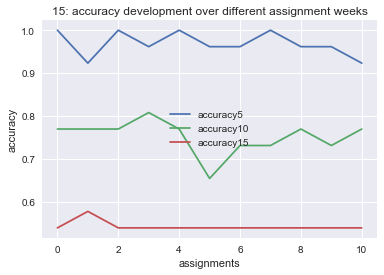

In [51]:
dt_model51 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model51.fit(X_train1,y_train5)
dt_model52 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model52.fit(X_train2,y_train5)
dt_model53 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model53.fit(X_train3,y_train5)
dt_model54 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model54.fit(X_train4,y_train5)
dt_model55 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model55.fit(X_train5,y_train5)
dt_model56 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model56.fit(X_train6,y_train5)
dt_model57 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model57.fit(X_train7,y_train5)
dt_model58 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model58.fit(X_train8,y_train5)
dt_model59 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model59.fit(X_train9,y_train5)
dt_model510 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model510.fit(X_train10,y_train5)
dt_model511 =  RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)
dt_model511.fit(X_train11,y_train5)


acc5 = pd.Series([accuracy_score(y_test5, dt_model51.predict(X_test1)), 
                accuracy_score(y_test5, dt_model52.predict(X_test2)),
                accuracy_score(y_test5, dt_model53.predict(X_test3)),
                accuracy_score(y_test5, dt_model54.predict(X_test4)),
                accuracy_score(y_test5, dt_model55.predict(X_test5)),
                accuracy_score(y_test5, dt_model56.predict(X_test6)),
                accuracy_score(y_test5, dt_model57.predict(X_test7)),
                accuracy_score(y_test5, dt_model58.predict(X_test8)),
                accuracy_score(y_test5, dt_model59.predict(X_test9)),
                accuracy_score(y_test5, dt_model510.predict(X_test10)),
                accuracy_score(y_test5, dt_model511.predict(X_test11))])

df = pd.DataFrame({"accuracy5" : acc5})

# f1_5_0 = pd.Series([f_one(dt_model51, y_test5, X_test1, 0), 
#                    f_one(dt_model52, y_test5, X_test2, 0), 
#                    f_one(dt_model53, y_test5, X_test3, 0), 
#                    f_one(dt_model54, y_test5, X_test4, 0), 
#                    f_one(dt_model55, y_test5, X_test5, 0), 
#                    f_one(dt_model56, y_test5, X_test6, 0), 
#                    f_one(dt_model57, y_test5, X_test7, 0), 
#                    f_one(dt_model58, y_test5, X_test8, 0), 
#                    f_one(dt_model59, y_test5, X_test9, 0), 
#                    f_one(dt_model510, y_test5, X_test10, 0),
#                    f_one(dt_model511, y_test5, X_test11, 0)])
# f1_5_1 = pd.Series([f_one(dt_model51, y_test5, X_test1, 1), 
#                    f_one(dt_model52, y_test5, X_test2, 1), 
#                    f_one(dt_model53, y_test5, X_test3, 1), 
#                    f_one(dt_model54, y_test5, X_test4, 1), 
#                    f_one(dt_model55, y_test5, X_test5, 1), 
#                    f_one(dt_model56, y_test5, X_test6, 1), 
#                    f_one(dt_model57, y_test5, X_test7, 1), 
#                    f_one(dt_model58, y_test5, X_test8, 1), 
#                    f_one(dt_model59, y_test5, X_test9, 1), 
#                    f_one(dt_model510, y_test5, X_test10, 1),
#                    f_one(dt_model511, y_test5, X_test11, 1)])
# f1_5_2 = pd.Series([f_one(dt_model51, y_test5, X_test1, 2), 
#                    f_one(dt_model52, y_test5, X_test2, 2), 
#                    f_one(dt_model53, y_test5, X_test3, 2), 
#                    f_one(dt_model54, y_test5, X_test4, 2), 
#                    f_one(dt_model55, y_test5, X_test5, 2), 
#                    f_one(dt_model56, y_test5, X_test6, 2), 
#                    f_one(dt_model57, y_test5, X_test7, 2), 
#                    f_one(dt_model58, y_test5, X_test8, 2), 
#                    f_one(dt_model59, y_test5, X_test9, 2), 
#                    f_one(dt_model510, y_test5, X_test10, 2),
#                    f_one(dt_model511, y_test5, X_test11, 2)])
				
# df = df.assign(f1_5_0 = f1_5_0)
# df = df.assign(f1_5_1 = f1_5_1)
# df = df.assign(f1_5_2 = f1_5_2)
				
#plt.hist(df["week"])
plt.plot(df["accuracy5"])
plt.xlabel('assignments')
plt.ylabel('accuracy')
plt.title('5: accuracy development over different assignment weeks')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

#########################################################################################

dt_model101 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model101.fit(X_train1,y_train10)
dt_model102 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model102.fit(X_train2,y_train10)
dt_model103 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model103.fit(X_train3,y_train10)
dt_model104 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model104.fit(X_train4,y_train10)
dt_model105 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model105.fit(X_train5,y_train10)
dt_model106 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model106.fit(X_train6,y_train10)
dt_model107 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model107.fit(X_train7,y_train10)
dt_model108 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model108.fit(X_train8,y_train10)
dt_model109 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model109.fit(X_train9,y_train10)
dt_model1010 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model1010.fit(X_train10,y_train10)
dt_model1011 =  RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)
dt_model1011.fit(X_train11,y_train10)


acc10 = pd.Series([accuracy_score(y_test10, dt_model101.predict(X_test1)), 
                accuracy_score(y_test10, dt_model102.predict(X_test2)),
                accuracy_score(y_test10, dt_model103.predict(X_test3)),
                accuracy_score(y_test10, dt_model104.predict(X_test4)),
                accuracy_score(y_test10, dt_model105.predict(X_test5)),
                accuracy_score(y_test10, dt_model106.predict(X_test6)),
                accuracy_score(y_test10, dt_model107.predict(X_test7)),
                accuracy_score(y_test10, dt_model108.predict(X_test8)),
                accuracy_score(y_test10, dt_model109.predict(X_test9)),
                accuracy_score(y_test10, dt_model1010.predict(X_test10)),
                accuracy_score(y_test10, dt_model1011.predict(X_test11))])	
# f1_10_0 = pd.Series([f_one(dt_model101, y_test10, X_test1, 0), 
#                    f_one(dt_model102, y_test10, X_test2, 0), 
#                    f_one(dt_model103, y_test10, X_test3, 0), 
#                    f_one(dt_model104, y_test10, X_test4, 0), 
#                    f_one(dt_model105, y_test10, X_test5, 0), 
#                    f_one(dt_model106, y_test10, X_test6, 0), 
#                    f_one(dt_model107, y_test10, X_test7, 0), 
#                    f_one(dt_model108, y_test10, X_test8, 0), 
#                    f_one(dt_model109, y_test10, X_test9, 0), 
#                    f_one(dt_model1010, y_test10, X_test10, 0),
#                    f_one(dt_model1011, y_test10, X_test11, 0)])
# f1_10_1 = pd.Series([f_one(dt_model101, y_test10, X_test1, 1), 
#                    f_one(dt_model102, y_test10, X_test2, 1), 
#                    f_one(dt_model103, y_test10, X_test3, 1), 
#                    f_one(dt_model104, y_test10, X_test4, 1), 
#                    f_one(dt_model105, y_test10, X_test5, 1), 
#                    f_one(dt_model106, y_test10, X_test6, 1), 
#                    f_one(dt_model107, y_test10, X_test7, 1), 
#                    f_one(dt_model108, y_test10, X_test8, 1), 
#                    f_one(dt_model109, y_test10, X_test9, 1), 
#                    f_one(dt_model1010, y_test10, X_test10, 1),
#                    f_one(dt_model1011, y_test10, X_test11, 1)])
# f1_10_2 = pd.Series([f_one(dt_model101, y_test10, X_test1, 2), 
#                    f_one(dt_model102, y_test10, X_test2, 2), 
#                    f_one(dt_model103, y_test10, X_test3, 2), 
#                    f_one(dt_model104, y_test10, X_test4, 2), 
#                    f_one(dt_model105, y_test10, X_test5, 2), 
#                    f_one(dt_model106, y_test10, X_test6, 2), 
#                    f_one(dt_model107, y_test10, X_test7, 2), 
#                    f_one(dt_model108, y_test10, X_test8, 2), 
#                    f_one(dt_model109, y_test10, X_test9, 2), 
#                    f_one(dt_model1010, y_test10, X_test10, 2),
#                    f_one(dt_model1011, y_test10, X_test11, 2)])
				
df = df.assign(accuracy10 = acc10)
# df = df.assign(f1_10_0 = f1_10_0)
# df = df.assign(f1_10_1 = f1_10_1)
# df = df.assign(f1_10_2 = f1_10_2)
				
#plt.hist(df["week"])
plt.plot(df["accuracy10"])
plt.xlabel('assignments')
plt.ylabel('accuracy')
plt.title('10: accuracy development over different assignment weeks')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

#########################################################################################

dt_model151 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model151.fit(X_train1,y_train15)
dt_model152 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model152.fit(X_train2,y_train15)
dt_model153 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model153.fit(X_train3,y_train15)
dt_model154 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model154.fit(X_train4,y_train15)
dt_model155 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model155.fit(X_train5,y_train15)
dt_model156 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model156.fit(X_train6,y_train15)
dt_model157 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model157.fit(X_train7,y_train15)
dt_model158 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model158.fit(X_train8,y_train15)
dt_model159 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model159.fit(X_train9,y_train15)
dt_model1510 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model1510.fit(X_train10,y_train15)
dt_model1511 =  RandomForestClassifier(max_depth=2, n_estimators=30, random_state=42)
dt_model1511.fit(X_train11,y_train15)


acc15 = pd.Series([accuracy_score(y_test15, dt_model151.predict(X_test1)), 
                accuracy_score(y_test15, dt_model152.predict(X_test2)),
                accuracy_score(y_test15, dt_model153.predict(X_test3)),
                accuracy_score(y_test15, dt_model154.predict(X_test4)),
                accuracy_score(y_test15, dt_model155.predict(X_test5)),
                accuracy_score(y_test15, dt_model156.predict(X_test6)),
                accuracy_score(y_test15, dt_model157.predict(X_test7)),
                accuracy_score(y_test15, dt_model158.predict(X_test8)),
                accuracy_score(y_test15, dt_model159.predict(X_test9)),
                accuracy_score(y_test15, dt_model1510.predict(X_test10)),
                accuracy_score(y_test15, dt_model1511.predict(X_test11))])
# f1_15_0 = pd.Series([f_one(dt_model151, y_test15, X_test1, 0), 
#                    f_one(dt_model152, y_test15, X_test2, 0), 
#                    f_one(dt_model153, y_test15, X_test3, 0), 
#                    f_one(dt_model154, y_test15, X_test4, 0), 
#                    f_one(dt_model155, y_test15, X_test5, 0), 
#                    f_one(dt_model156, y_test15, X_test6, 0), 
#                    f_one(dt_model157, y_test15, X_test7, 0), 
#                    f_one(dt_model158, y_test15, X_test8, 0), 
#                    f_one(dt_model159, y_test15, X_test9, 0), 
#                    f_one(dt_model1510, y_test15, X_test10, 0),
#                    f_one(dt_model1511, y_test15, X_test11, 0)])
# f1_15_1 = pd.Series([f_one(dt_model151, y_test15, X_test1, 0), 
#                    f_one(dt_model152, y_test15, X_test2, 1), 
#                    f_one(dt_model153, y_test15, X_test3, 1), 
#                    f_one(dt_model154, y_test15, X_test4, 1), 
#                    f_one(dt_model155, y_test15, X_test5, 1), 
#                    f_one(dt_model156, y_test15, X_test6, 1), 
#                    f_one(dt_model157, y_test15, X_test7, 1), 
#                    f_one(dt_model158, y_test15, X_test8, 1), 
#                    f_one(dt_model159, y_test15, X_test9, 1), 
#                    f_one(dt_model1510, y_test15, X_test10, 1),
#                    f_one(dt_model1511, y_test15, X_test11, 1)])
# f1_15_2 = pd.Series([f_one(dt_model151, y_test15, X_test1, 2), 
#                    f_one(dt_model152, y_test15, X_test2, 2), 
#                    f_one(dt_model153, y_test15, X_test3, 2), 
#                    f_one(dt_model154, y_test15, X_test4, 2), 
#                    f_one(dt_model155, y_test15, X_test5, 2), 
#                    f_one(dt_model156, y_test15, X_test6, 2), 
#                    f_one(dt_model157, y_test15, X_test7, 2), 
#                    f_one(dt_model158, y_test15, X_test8, 2), 
#                    f_one(dt_model159, y_test15, X_test9, 2), 
#                    f_one(dt_model1510, y_test15, X_test10, 2),
#                    f_one(dt_model1511, y_test15, X_test11, 2)])
				
df = df.assign(accuracy15 = acc15)
# df = df.assign(f1_15_0 = f1_15_0)
# df = df.assign(f1_15_1 = f1_15_1)
# df = df.assign(f1_15_2 = f1_15_2)
				
#plt.hist(df["week"])
plt.plot(df["accuracy15"])
plt.xlabel('assignments')
plt.ylabel('accuracy')
plt.legend()
plt.title('15: accuracy development over different assignment weeks')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

#########################################################################################

# dt_model201 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model201.fit(X_train1,y_train20)
# dt_model202 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model202.fit(X_train2,y_train20)
# dt_model203 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model203.fit(X_train3,y_train20)
# dt_model204 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model204.fit(X_train4,y_train20)
# dt_model205 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model205.fit(X_train5,y_train20)
# dt_model206 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model206.fit(X_train6,y_train20)
# dt_model207 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model207.fit(X_train7,y_train20)
# dt_model208 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model208.fit(X_train8,y_train20)
# dt_model209 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model209.fit(X_train9,y_train20)
# dt_model2010 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model2010.fit(X_train10,y_train20)
# dt_model2011 =  RandomForestClassifier(max_depth=4, n_estimators=60, random_state=42)
# dt_model2011.fit(X_train11,y_train20)


# acc20 = pd.Series([accuracy_score(y_test20, dt_model201.predict(X_test1)), 
#                 accuracy_score(y_test20, dt_model202.predict(X_test2)),
#                 accuracy_score(y_test20, dt_model203.predict(X_test3)),
#                 accuracy_score(y_test20, dt_model204.predict(X_test4)),
#                 accuracy_score(y_test20, dt_model205.predict(X_test5)),
#                 accuracy_score(y_test20, dt_model206.predict(X_test6)),
#                 accuracy_score(y_test20, dt_model207.predict(X_test7)),
#                 accuracy_score(y_test20, dt_model208.predict(X_test8)),
#                 accuracy_score(y_test20, dt_model209.predict(X_test9)),
#                 accuracy_score(y_test20, dt_model2010.predict(X_test10)),
#                 accuracy_score(y_test20, dt_model2011.predict(X_test11))])
# f1_20_0 = pd.Series([f_one(dt_model201, y_test20, X_test1, 0), 
#                    f_one(dt_model202, y_test20, X_test2, 0), 
#                    f_one(dt_model203, y_test20, X_test3, 0), 
#                    f_one(dt_model204, y_test20, X_test4, 0), 
#                    f_one(dt_model205, y_test20, X_test5, 0), 
#                    f_one(dt_model206, y_test20, X_test6, 0), 
#                    f_one(dt_model207, y_test20, X_test7, 0), 
#                    f_one(dt_model208, y_test20, X_test8, 0), 
#                    f_one(dt_model209, y_test20, X_test9, 0), 
#                    f_one(dt_model2010, y_test20, X_test10, 0),
#                    f_one(dt_model2011, y_test20, X_test11, 0)])
# f1_20_1 = pd.Series([f_one(dt_model201, y_test20, X_test1, 1), 
#                    f_one(dt_model202, y_test20, X_test2, 1), 
#                    f_one(dt_model203, y_test20, X_test3, 1), 
#                    f_one(dt_model204, y_test20, X_test4, 1), 
#                    f_one(dt_model205, y_test20, X_test5, 1), 
#                    f_one(dt_model206, y_test20, X_test6, 1), 
#                    f_one(dt_model207, y_test20, X_test7, 1), 
#                    f_one(dt_model208, y_test20, X_test8, 1), 
#                    f_one(dt_model209, y_test20, X_test9, 1), 
#                    f_one(dt_model2010, y_test20, X_test10, 1),
#                    f_one(dt_model2011, y_test20, X_test11, 1)])
# f1_20_2 = pd.Series([f_one(dt_model201, y_test20, X_test1, 2), 
#                    f_one(dt_model202, y_test20, X_test2, 2), 
#                    f_one(dt_model203, y_test20, X_test3, 2), 
#                    f_one(dt_model204, y_test20, X_test4, 2), 
#                    f_one(dt_model205, y_test20, X_test5, 2), 
#                    f_one(dt_model206, y_test20, X_test6, 2), 
#                    f_one(dt_model207, y_test20, X_test7, 2), 
#                    f_one(dt_model208, y_test20, X_test8, 2), 
#                    f_one(dt_model209, y_test20, X_test9, 2), 
#                    f_one(dt_model2010, y_test20, X_test10, 2),
#                    f_one(dt_model2011, y_test20, X_test11, 2)])
				
# df = df.assign(accuracy20 = acc20)
# df = df.assign(f1_20_0 = f1_20_0)
# df = df.assign(f1_20_1 = f1_20_1)
# df = df.assign(f1_20_2 = f1_20_2)

# #plt.hist(df["week"])
# plt.plot(df["accuracy20"])
# plt.xlabel('assignments')
# plt.ylabel('accuracy')
# plt.title('3 Classes: Accuracy Development over Different Weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

#########################################################################################

In [52]:
# plt.plot(df["f1_5_0"])
# plt.plot(df["f1_5_1"])
# plt.plot(df["f1_5_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('5: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

In [53]:
# plt.plot(df["f1_10_0"])
# plt.plot(df["f1_10_1"])
# plt.plot(df["f1_10_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('10: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

In [54]:
# plt.plot(df["f1_15_0"])
# plt.plot(df["f1_15_1"])
# plt.plot(df["f1_15_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('15: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

In [55]:
# plt.plot(df["f1_20_0"])
# plt.plot(df["f1_20_1"])
# plt.plot(df["f1_20_2"])
# plt.xlabel('assignments')
# plt.ylabel('f1')
# plt.title('20: f1 development over different assignment weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

In [56]:
# plt.plot(df["f1_5_1"])
# plt.plot(df["f1_10_1"])
# plt.plot(df["f1_15_1"])
# # plt.plot(df["f1_20_1"])
# plt.xlabel('Assignments')
# plt.ylabel('f1')
# plt.title('F1 Development for Group 1 over Different Weeks')
# plt.legend()
# #plt.axis([40, 160, 0, 0.03])
# plt.grid(True)